In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
import pynwb
from pynwb import NWBFile
from pynwb.ecephys import ElectricalSeries
from pynwb.misc import DecompositionSeries  # CORRECT IMPORT!
from datetime import datetime
import os
import re
import time

# Frequency bands
BANDS = {
    'delta': (1.0, 4.0),
    'theta': (4.0, 8.0),
    'alpha': (8.0, 12.0),
    'beta': (15.0, 25.0),
    'gamma': (25.0, 70.0),
    'high_gamma': (70.0, 170.0)
}

# File paths
INPUT_PATH = '/mnt/NAS/iEEG_EHR_converted/sub-259/ses-01/ieeg/sub-259_ses-01_run-IA6194BZ.nwb'
OUTPUT_PATH = '/mnt/NAS/iEEG_EHR_converted/fft/sub-259/ses-01/ieeg/sub-259_ses-01_run-IA6194BZ_bipolar_psd.nwb'

print("✓ Imports and setup complete")

In [27]:
def parse_electrode_shaft(location):
    """Extract shaft name and contact number from location"""
    match = re.match(r'^([A-Za-z]+)(\d+)$', location)
    if match:
        shaft = match.group(1)
        number = int(match.group(2))
        return shaft, number
    else:
        return None, None

def create_bipolar_pairs(elec_df):
    """Create bipolar electrode pairs from electrode dataframe"""
    
    elec_df = elec_df.copy()
    elec_df['shaft'] = None
    elec_df['contact_num'] = None
    
    for idx, row in elec_df.iterrows():
        shaft, num = parse_electrode_shaft(row['location'])
        elec_df.at[idx, 'shaft'] = shaft
        elec_df.at[idx, 'contact_num'] = num
    
    valid_parse = elec_df['shaft'].notna()
    if (~valid_parse).sum() > 0:
        print(f"  Warning: {(~valid_parse).sum()} electrodes have unparseable locations")
        elec_df = elec_df[valid_parse].copy()
    
    pairs = []
    grouped = elec_df.groupby('shaft')
    
    for shaft_name, shaft_df in grouped:
        shaft_df = shaft_df.sort_values('contact_num')
        contacts = [(idx, row) for idx, row in shaft_df.iterrows()]
        
        for i in range(len(contacts) - 1):
            anode_idx, anode = contacts[i]
            cathode_idx, cathode = contacts[i + 1]
            
            if cathode['contact_num'] - anode['contact_num'] == 1:
                pair = {
                    'anode_idx': anode_idx,
                    'cathode_idx': cathode_idx,
                    'anode_location': anode['location'],
                    'cathode_location': cathode['location'],
                    'location': f"{anode['location']}-{cathode['location']}",
                    'shaft': shaft_name
                }
                pairs.append(pair)
    
    print(f"  Created {len(pairs)} bipolar pairs from {len(elec_df)} electrodes")
    
    return pairs, elec_df

def create_bipolar_electrode_table(elec_df, pairs):
    """Create enhanced electrode table for bipolar pairs"""
    
    coord_systems = ['MNI', 'LEPTO', 'MGRID', 'subINF', 'fsaverageINF', 'ScannerNativeRAS']
    coord_columns = []
    for coord_sys in coord_systems:
        for axis in ['_coord_1', '_coord_2', '_coord_3']:
            col_name = f"{coord_sys}{axis}"
            if col_name in elec_df.columns:
                coord_columns.append(col_name)
    
    single_columns = ['group', 'group_name']
    
    bipolar_rows = []
    
    for pair in pairs:
        anode_idx = pair['anode_idx']
        cathode_idx = pair['cathode_idx']
        
        anode_row = elec_df.loc[anode_idx]
        cathode_row = elec_df.loc[cathode_idx]
        
        new_row = {}
        new_row['location'] = pair['location']
        
        for col in single_columns:
            if col in elec_df.columns:
                new_row[col] = anode_row[col]
        
        for col in coord_columns:
            anode_val = anode_row[col]
            cathode_val = cathode_row[col]
            
            if pd.notna(anode_val) and pd.notna(cathode_val):
                new_row[col] = (anode_val + cathode_val) / 2
            elif pd.notna(anode_val):
                new_row[col] = anode_val
            elif pd.notna(cathode_val):
                new_row[col] = cathode_val
            else:
                new_row[col] = np.nan
        
        for col in elec_df.columns:
            if col not in single_columns and col not in coord_columns and col != 'location':
                new_row[f"{col}_anode"] = anode_row[col]
                new_row[f"{col}_cathode"] = cathode_row[col]
        
        bipolar_rows.append(new_row)
    
    return pd.DataFrame(bipolar_rows)

def compute_time_varying_band_power(bipolar_data, sfreq, bands, window_sec=1.0, overlap_frac=0.5):
    """Compute time-varying band power using scipy spectrogram"""
    
    n_samples, n_channels = bipolar_data.shape
    
    #nperseg = int(window_sec * sfreq)
    nperseg = 500
    noverlap = int(nperseg * overlap_frac)  
    
    freqs, times, Sxx = signal.spectrogram(
        bipolar_data[:, 0],
        fs=sfreq,
        noverlap=noverlap,
        nperseg=500,
        window='hann'
    )
    
    n_windows = len(times)
    n_bands = len(bands)
    band_power_time = np.zeros((n_windows, n_channels, n_bands))
    
    print(f"  Computing spectrogram: {n_windows} time windows, {len(freqs)} frequency bins")
    
    for ch_idx in range(n_channels):
        freqs, times, Sxx = signal.spectrogram(
            bipolar_data[:, ch_idx],
            fs=sfreq,
            nperseg=nperseg,
            noverlap=noverlap,
            window='hann'
        )
        
        for band_idx, (band_name, (fmin, fmax)) in enumerate(bands.items()):
            freq_mask = (freqs >= fmin) & (freqs < fmax)
            band_power_time[:, ch_idx, band_idx] = Sxx[freq_mask, :].mean(axis=0)
        
        if (ch_idx + 1) % 10 == 0 or ch_idx == n_channels - 1:
            print(f"  Progress: {ch_idx+1}/{n_channels} channels", end='\r')
    
    print()
    
    return band_power_time, times

print("✓ Helper functions defined")

✓ Helper functions defined


In [23]:
start_time = time.time()

print("=" * 70)
print(f"STEP 1: Loading raw data")
print("=" * 70)

# Load raw NWB
io_in = pynwb.NWBHDF5IO(INPUT_PATH, 'r')
nwb_in = io_in.read()

# Get raw series
series = nwb_in.acquisition['ElectricalSeries_sEEG']
sfreq = series.rate
n_samples, n_channels = series.data.shape
duration_min = n_samples / sfreq / 60

print(f"File info: {n_samples:,} samples, {n_channels} channels, {sfreq} Hz")
print(f"Duration: {duration_min:.1f} minutes")

# Load data (SLOW - ~5 min)
print(f"\nLoading data (this takes ~5 minutes)...")
print(f"Started at: {time.strftime('%H:%M:%S')}")
data = series.data[:]
load_time = time.time() - start_time
print(f"✓ Loaded in {load_time:.1f}s ({load_time/60:.1f} min)")

# Get electrode metadata
elec_indices = series.electrodes.data[:]
elec_df = nwb_in.electrodes.to_dataframe().iloc[elec_indices]

print(f"\n✓ Using all {len(elec_df)} electrodes (no exclusions)")

# Create bipolar pairs
pairs, filtered_elec_df = create_bipolar_pairs(elec_df)

print(f"\n✓ Step 1 complete: {len(pairs)} bipolar pairs created")
print(f"  Time elapsed: {time.time() - start_time:.1f}s")

✓ Loaded in 120.6s (2.0 min)

✓ Using all 230 electrodes (no exclusions)
  Created 214 bipolar pairs from 230 electrodes

✓ Step 1 complete: 214 bipolar pairs created
  Time elapsed: 120.7s


In [24]:
step_start = time.time()

print("\n" + "=" * 70)
print(f"STEP 2: Computing bipolar re-referencing")
print("=" * 70)

# Compute bipolar data
bipolar_data = np.zeros((data.shape[0], len(pairs)), dtype=data.dtype)

for i, pair in enumerate(pairs):
    anode_col = np.where(elec_indices == pair['anode_idx'])[0][0]
    cathode_col = np.where(elec_indices == pair['cathode_idx'])[0][0]
    bipolar_data[:, i] = data[:, anode_col] - data[:, cathode_col]
    
    if (i + 1) % 10 == 0 or i == len(pairs) - 1:
        print(f"Progress: {i+1}/{len(pairs)} pairs", end='\r')

print()
bipolar_time = time.time() - step_start

print(f"\n✓ Bipolar data computed: {bipolar_data.shape}")
print(f"  Time: {bipolar_time:.2f}s")
print(f"  Total elapsed: {time.time() - start_time:.1f}s")


STEP 2: Computing bipolar re-referencing
Progress: 214/214 pairs

✓ Bipolar data computed: (7200000, 214)
  Time: 107.83s
  Total elapsed: 228.5s



CHECKING: Raw bipolar data for dropouts/artifacts

Raw bipolar data shape: (7200000, 214)
Duration: 120.0 minutes

Checking for channels with large zero segments...


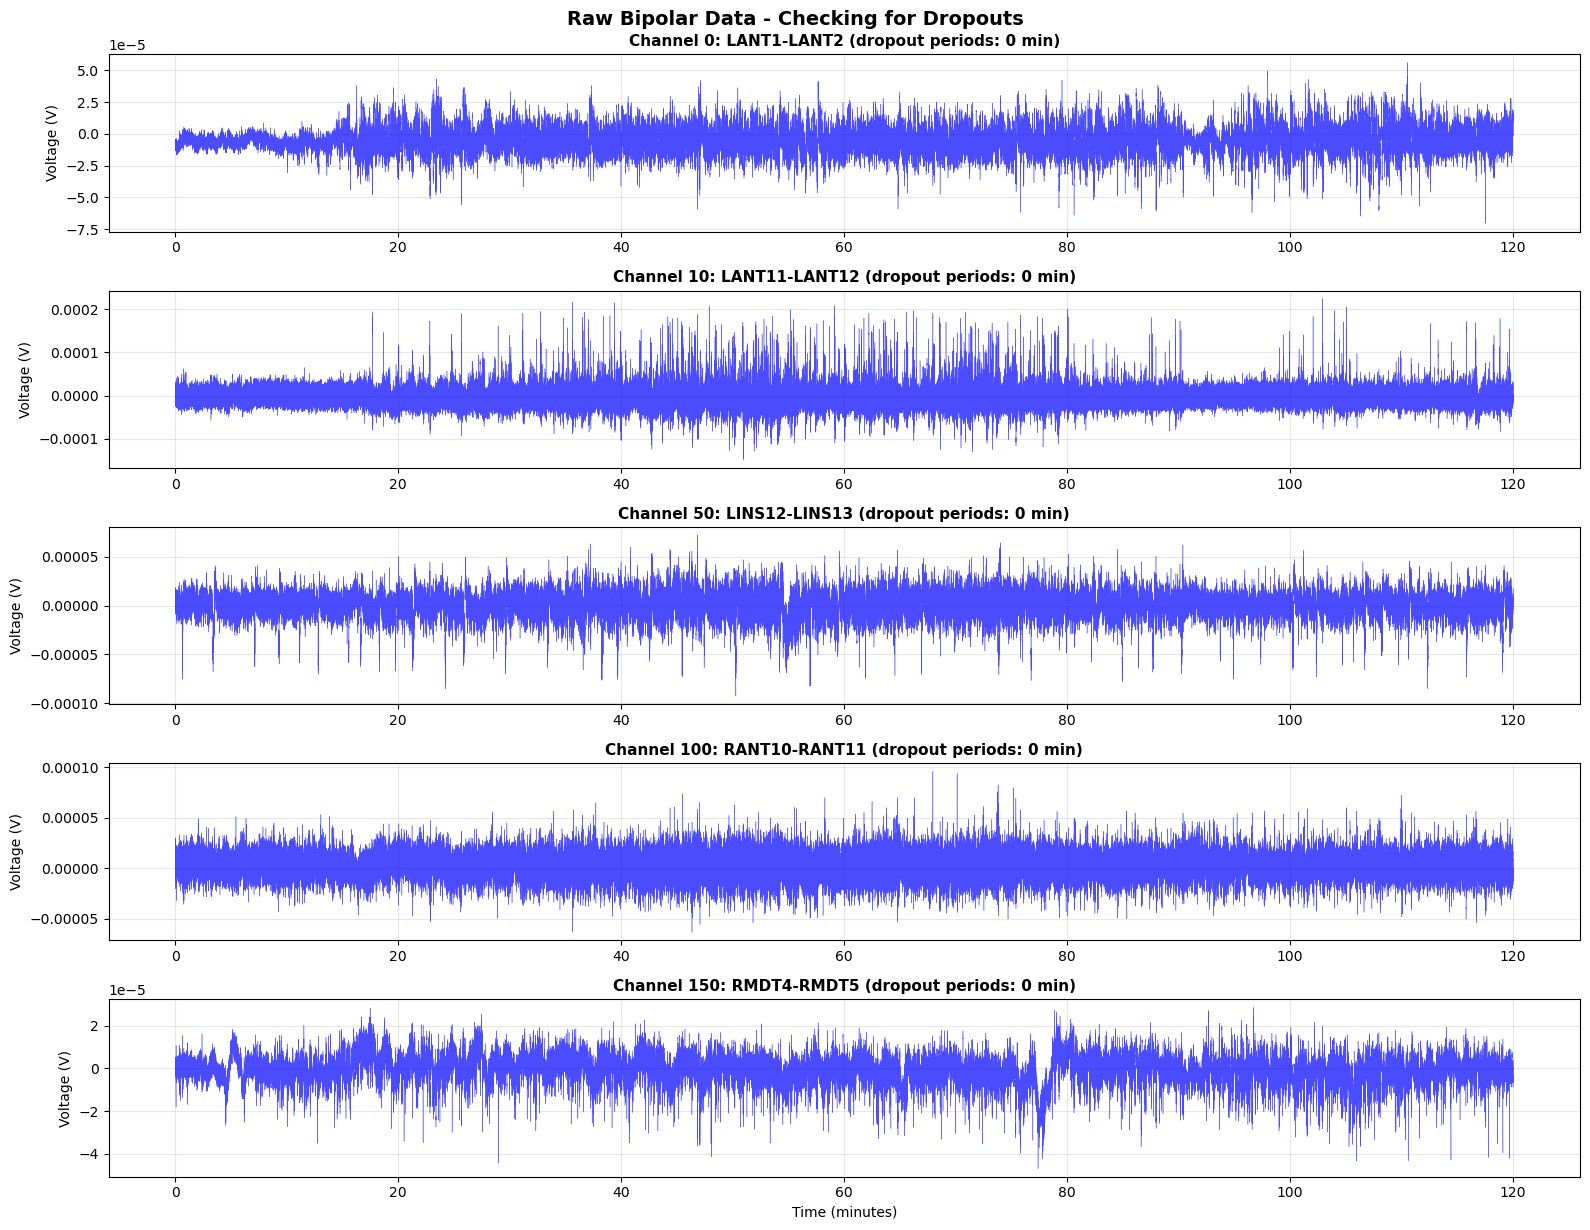


Summary by time segment:
    0.0- 10.0 min: mean_std=9.815e-06 V, zero_channels=0/214
   10.0- 20.0 min: mean_std=1.064e-05 V, zero_channels=0/214
   20.0- 30.0 min: mean_std=1.175e-05 V, zero_channels=0/214
   30.0- 40.0 min: mean_std=1.279e-05 V, zero_channels=0/214
   40.0- 50.0 min: mean_std=1.584e-05 V, zero_channels=0/214
   50.0- 60.0 min: mean_std=1.646e-05 V, zero_channels=0/214
   60.0- 70.0 min: mean_std=1.536e-05 V, zero_channels=0/214
   70.0- 80.0 min: mean_std=1.611e-05 V, zero_channels=0/214
   80.0- 90.0 min: mean_std=1.351e-05 V, zero_channels=0/214
   90.0-100.0 min: mean_std=1.154e-05 V, zero_channels=0/214
  100.0-110.0 min: mean_std=1.274e-05 V, zero_channels=0/214
  110.0-120.0 min: mean_std=1.210e-05 V, zero_channels=0/214



In [25]:
# ============================================================================
# CHECK: Look at raw bipolar data for dropouts
# ============================================================================
import matplotlib.pyplot as plt
print("\n" + "=" * 70)
print("CHECKING: Raw bipolar data for dropouts/artifacts")
print("=" * 70)

# Check for zero/near-zero segments in raw bipolar data
n_samples, n_channels_bipolar = bipolar_data.shape
duration_min = n_samples / sfreq / 60

print(f"\nRaw bipolar data shape: {bipolar_data.shape}")
print(f"Duration: {duration_min:.1f} minutes")

# Check for problematic channels
print(f"\nChecking for channels with large zero segments...")

time_vector = np.arange(n_samples) / sfreq / 60  # minutes

# Sample a few channels to plot
channels_to_check = [0, 10, 50, 100, 150]  # Spread across channels
channels_to_check = [ch for ch in channels_to_check if ch < n_channels_bipolar]

fig, axes = plt.subplots(len(channels_to_check), 1, figsize=(16, 2.5 * len(channels_to_check)))

if len(channels_to_check) == 1:
    axes = [axes]

for idx, ch_idx in enumerate(channels_to_check):
    ax = axes[idx]
    
    # Get channel name
    pair = pairs[ch_idx]
    channel_name = pair['location']
    
    # Plot raw bipolar signal
    signal_data = bipolar_data[:, ch_idx]
    ax.plot(time_vector, signal_data, linewidth=0.3, color='blue', alpha=0.7)
    
    # Calculate std in 1-minute windows to see if signal drops
    window_min = 1.0  # 1 minute windows
    window_samples = int(window_min * 60 * sfreq)
    n_windows = n_samples // window_samples
    
    stds = []
    window_times = []
    for i in range(n_windows):
        start = i * window_samples
        end = start + window_samples
        window_std = np.std(signal_data[start:end])
        stds.append(window_std)
        window_times.append((start + end) / 2 / sfreq / 60)
    
    # Mark time points where std drops significantly
    std_threshold = np.median(stds) * 0.1  # 10% of median std
    dropout_times = [t for t, s in zip(window_times, stds) if s < std_threshold]
    
    ax.set_ylabel('Voltage (V)', fontsize=10)
    ax.set_title(f'Channel {ch_idx}: {channel_name} (dropout periods: {len(dropout_times)} min)', 
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Highlight dropout regions
    if dropout_times:
        for dt in dropout_times:
            ax.axvspan(dt - 0.5, dt + 0.5, color='red', alpha=0.2)
    
    # Only show x-label on bottom plot
    if idx == len(channels_to_check) - 1:
        ax.set_xlabel('Time (minutes)', fontsize=10)

plt.suptitle('Raw Bipolar Data - Checking for Dropouts', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nSummary by time segment:")
segment_duration_min = 10  # Check 10-minute segments
segment_samples = int(segment_duration_min * 60 * sfreq)
n_segments = n_samples // segment_samples

for seg_idx in range(n_segments):
    start_sample = seg_idx * segment_samples
    end_sample = start_sample + segment_samples
    start_time = start_sample / sfreq / 60
    end_time = end_sample / sfreq / 60
    
    segment_data = bipolar_data[start_sample:end_sample, :]
    
    # Check how many channels are effectively zero in this segment
    channel_stds = np.std(segment_data, axis=0)
    zero_channels = np.sum(channel_stds < 1e-10)  # Very low std = likely zero/flat
    
    mean_std = np.mean(channel_stds)
    
    print(f"  {start_time:5.1f}-{end_time:5.1f} min: mean_std={mean_std:.3e} V, zero_channels={zero_channels}/{n_channels_bipolar}")

print("\n" + "=" * 70)

In [30]:
step_start = time.time()

print("\n" + "=" * 70)
print(f"STEP 3: Computing time-varying band power")
print("=" * 70)

band_power_time, times = compute_time_varying_band_power(
    bipolar_data, sfreq, BANDS, window_sec=1.0, overlap_frac=0.5
)

fft_time = time.time() - step_start

print(f"\n✓ Band power computed: {band_power_time.shape}")
print(f"  (time_windows={band_power_time.shape[0]}, channels={band_power_time.shape[1]}, bands={band_power_time.shape[2]})")
print(f"  Time: {fft_time:.1f}s")
print(f"  Total elapsed: {time.time() - start_time:.1f}s")


STEP 3: Computing time-varying band power
  Computing spectrogram: 28799 time windows, 251 frequency bins
  Progress: 214/214 channels

✓ Band power computed: (28799, 214, 6)
  (time_windows=28799, channels=214, bands=6)
  Time: 946.5s
  Total elapsed: 1769899051.3s



VALIDATION: Checking band power data

Data shape: (28799, 214, 6)
  (time_windows=28799, channels=214, bands=6)

Data quality checks:
  Has NaN: False
  Has Inf: False
  All zeros: False

Per-band statistics:
  delta        (  1-  4 Hz): mean=1.797e-11, std=1.101e-10, range=[2.400e-20, 1.738e-08]
  theta        (  4-  8 Hz): mean=5.636e-12, std=3.519e-11, range=[1.664e-17, 7.487e-09]
  alpha        (  8- 12 Hz): mean=2.642e-12, std=1.403e-11, range=[5.373e-18, 5.295e-09]
  beta         ( 15- 25 Hz): mean=3.558e-13, std=2.700e-12, range=[1.587e-17, 1.034e-09]
  gamma        ( 25- 70 Hz): mean=3.774e-14, std=1.468e-13, range=[1.960e-17, 5.655e-11]
  high_gamma   ( 70-170 Hz): mean=2.024e-15, std=5.400e-15, range=[9.390e-18, 9.991e-13]

Plotting first 5 channels for visual inspection...


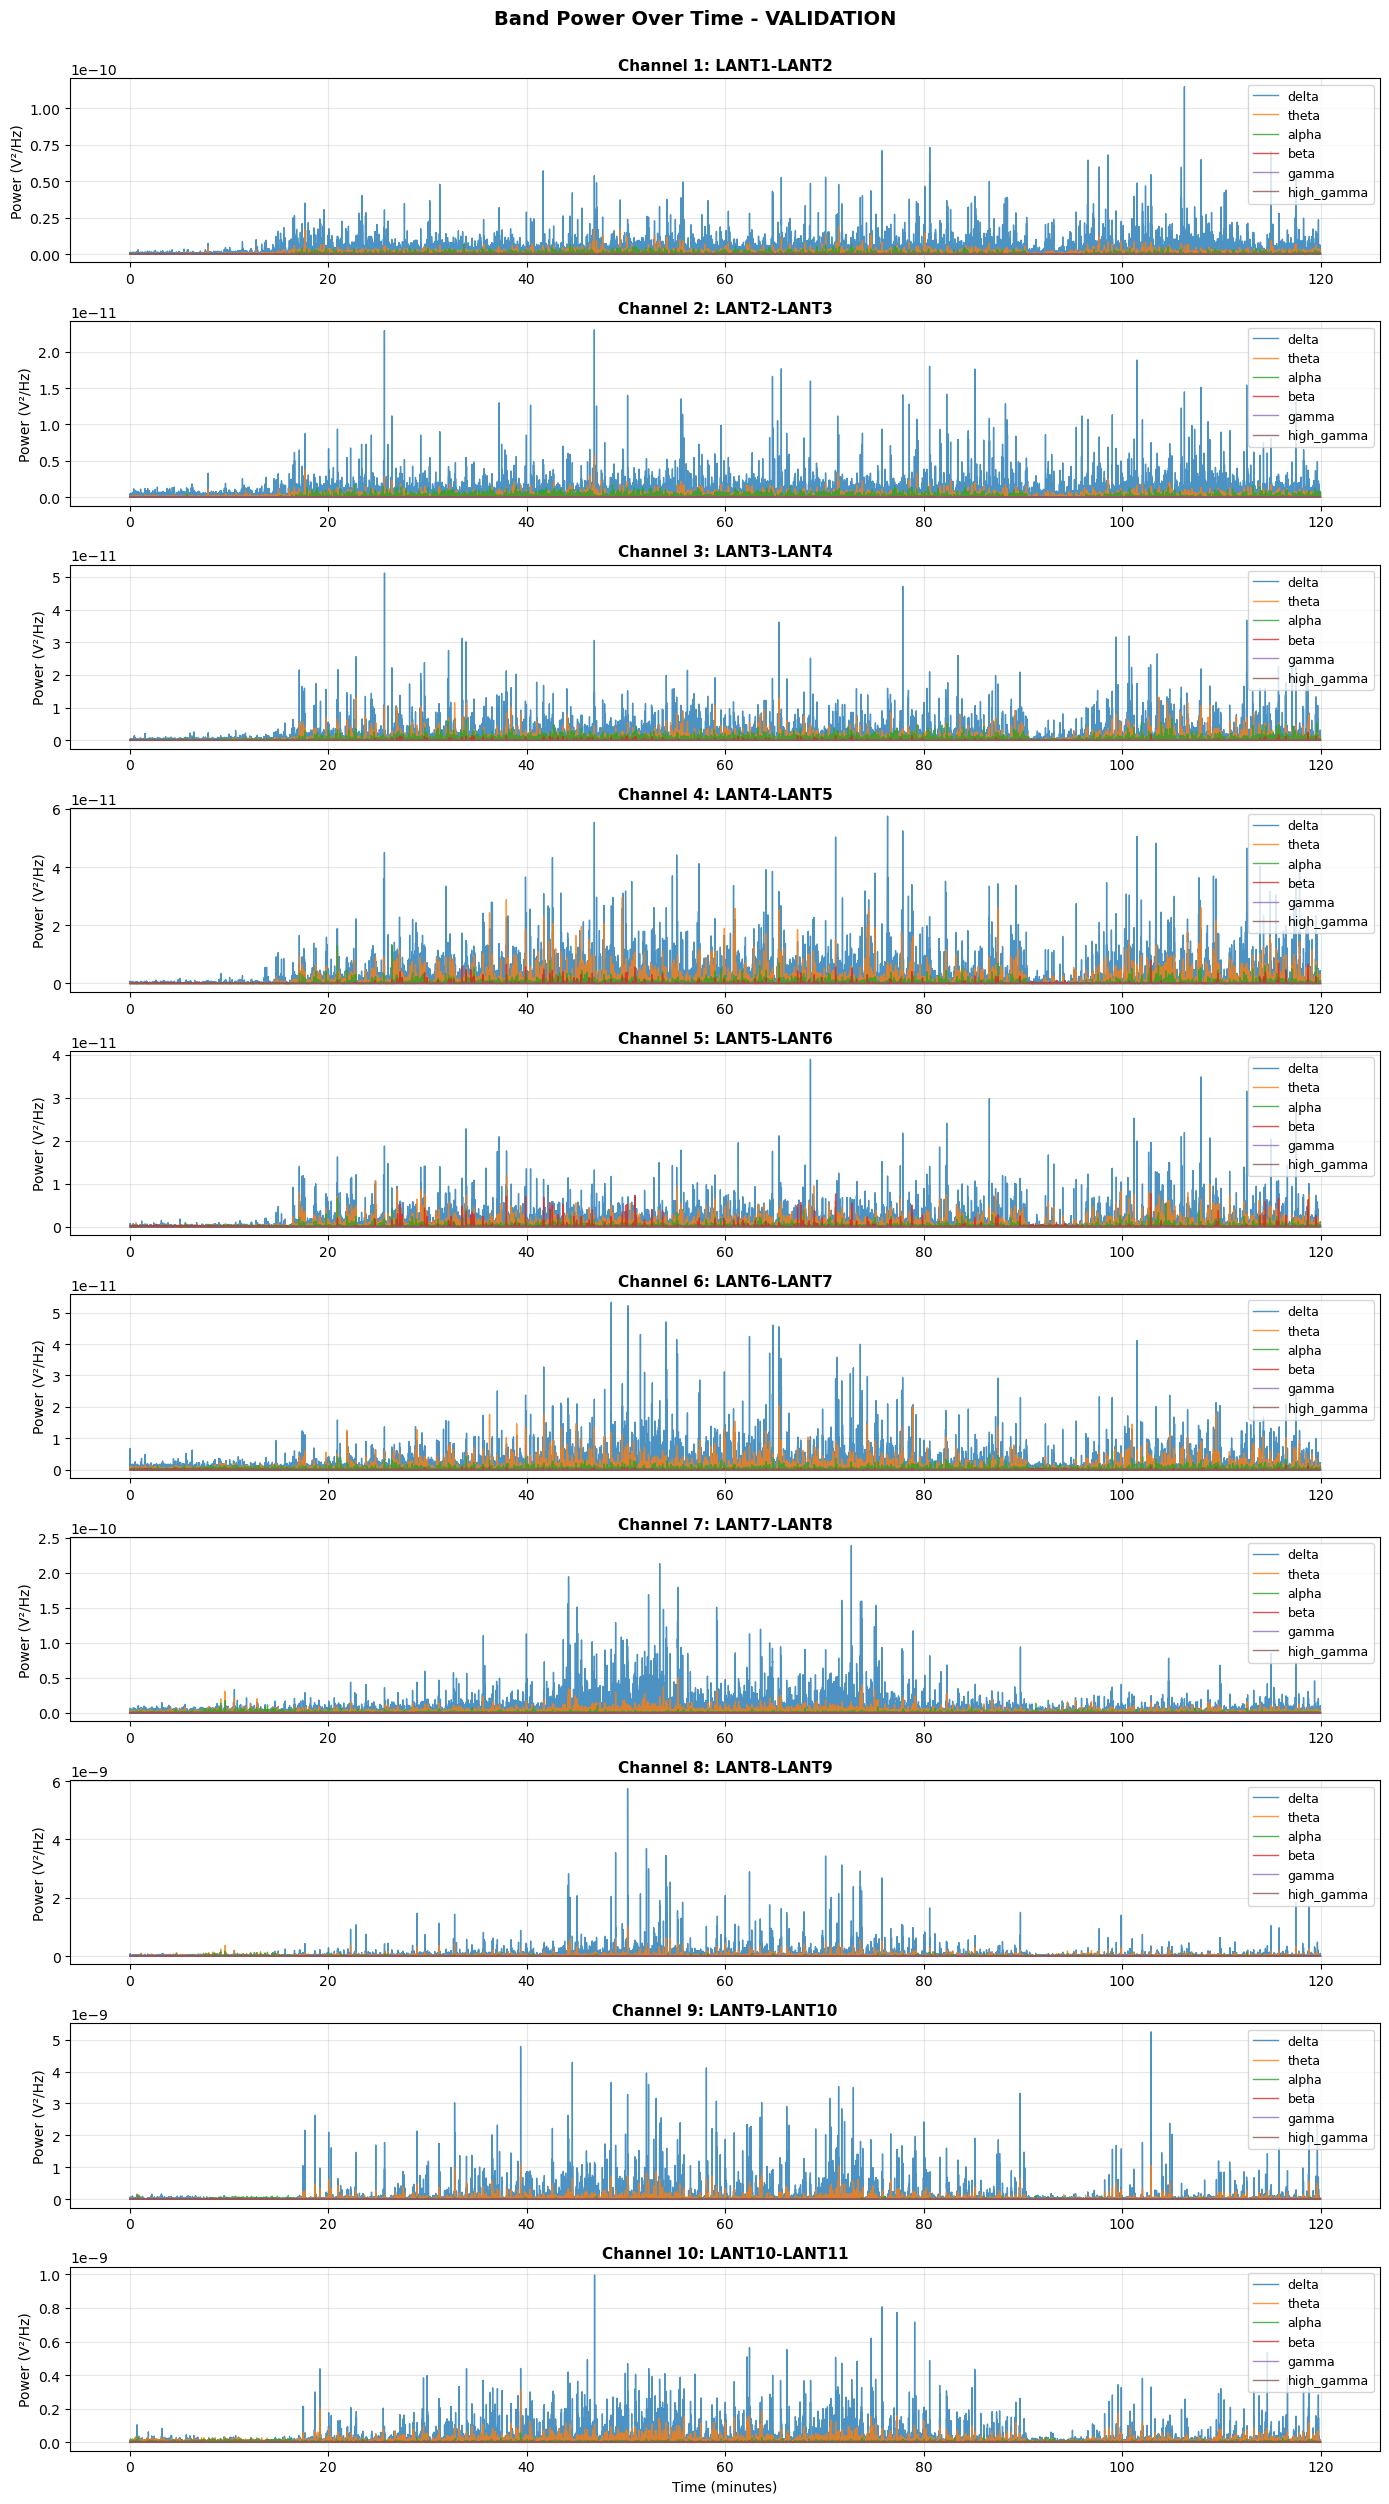


✓ VALIDATION COMPLETE - Review plots above

Does the data look reasonable?
- Are there visible oscillations/variations?
- Are different bands showing different power levels?
- Are there any flat lines or suspicious patterns?

If everything looks good, proceed to save to NWB.
If not, debug the FFT computation before saving.


In [31]:
# ============================================================================
# VALIDATION: Check band power data before saving
# ============================================================================
import matplotlib.pyplot as plt
print("\n" + "=" * 70)
print("VALIDATION: Checking band power data")
print("=" * 70)

# Basic checks
print(f"\nData shape: {band_power_time.shape}")
print(f"  (time_windows={band_power_time.shape[0]}, channels={band_power_time.shape[1]}, bands={band_power_time.shape[2]})")

# Check for issues
has_nan = np.any(np.isnan(band_power_time))
has_inf = np.any(np.isinf(band_power_time))
all_zero = np.allclose(band_power_time, 0)

print(f"\nData quality checks:")
print(f"  Has NaN: {has_nan}")
print(f"  Has Inf: {has_inf}")
print(f"  All zeros: {all_zero}")

# Statistics per band
print(f"\nPer-band statistics:")
for band_idx, (band_name, (fmin, fmax)) in enumerate(BANDS.items()):
    band_data = band_power_time[:, :, band_idx]
    print(f"  {band_name:12s} ({fmin:3.0f}-{fmax:3.0f} Hz): mean={band_data.mean():.3e}, std={band_data.std():.3e}, range=[{band_data.min():.3e}, {band_data.max():.3e}]")

# Quick visualization - plot first few channels
print(f"\nPlotting first 5 channels for visual inspection...")

n_channels_to_plot = min(10, band_power_time.shape[1])
time_plot = times / 60  # Convert to minutes

fig, axes = plt.subplots(n_channels_to_plot, 1, figsize=(14, 2.5 * n_channels_to_plot))

if n_channels_to_plot == 1:
    axes = [axes]

for ch_idx in range(n_channels_to_plot):
    ax = axes[ch_idx]
    
    # Get channel name
    pair = pairs[ch_idx]
    channel_name = pair['location']
    
    # Plot each frequency band
    for band_idx, band_name in enumerate(BANDS.keys()):
        power_trace = band_power_time[:, ch_idx, band_idx]
        ax.plot(time_plot, power_trace, label=band_name, linewidth=1, alpha=0.8)
    
    ax.set_ylabel('Power (V²/Hz)', fontsize=10)
    ax.set_title(f'Channel {ch_idx+1}: {channel_name}', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Only show x-label on bottom plot
    if ch_idx == n_channels_to_plot - 1:
        ax.set_xlabel('Time (minutes)', fontsize=10)

plt.suptitle('Band Power Over Time - VALIDATION', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✓ VALIDATION COMPLETE - Review plots above")
print("=" * 70)
print("\nDoes the data look reasonable?")
print("- Are there visible oscillations/variations?")
print("- Are different bands showing different power levels?")
print("- Are there any flat lines or suspicious patterns?")
print("\nIf everything looks good, proceed to save to NWB.")
print("If not, debug the FFT computation before saving.")


VALIDATION: Checking band power data (SECOND HALF ONLY)

Data shape: (28799, 214, 6)
  (time_windows=28799, channels=214, bands=6)

Focusing on SECOND HALF:
  Time window range: 40.0 - 120.0 minutes
  Number of windows: 19200

Data quality checks (second half):
  Has NaN: False
  Has Inf: False
  All zeros: False

Per-band statistics (SECOND HALF ONLY):
  delta        (  1-  4 Hz): mean=2.050e-11, std=1.146e-10, range=[2.400e-20, 1.612e-08]
  theta        (  4-  8 Hz): mean=5.989e-12, std=3.457e-11, range=[2.989e-17, 6.253e-09]
  alpha        (  8- 12 Hz): mean=2.563e-12, std=1.364e-11, range=[5.373e-18, 5.295e-09]
  beta         ( 15- 25 Hz): mean=3.325e-13, std=2.740e-12, range=[1.587e-17, 1.034e-09]
  gamma        ( 25- 70 Hz): mean=3.724e-14, std=1.430e-13, range=[2.005e-17, 5.295e-11]
  high_gamma   ( 70-170 Hz): mean=1.940e-15, std=4.338e-15, range=[9.390e-18, 7.821e-13]

Plotting first 5 channels - SECOND HALF only...


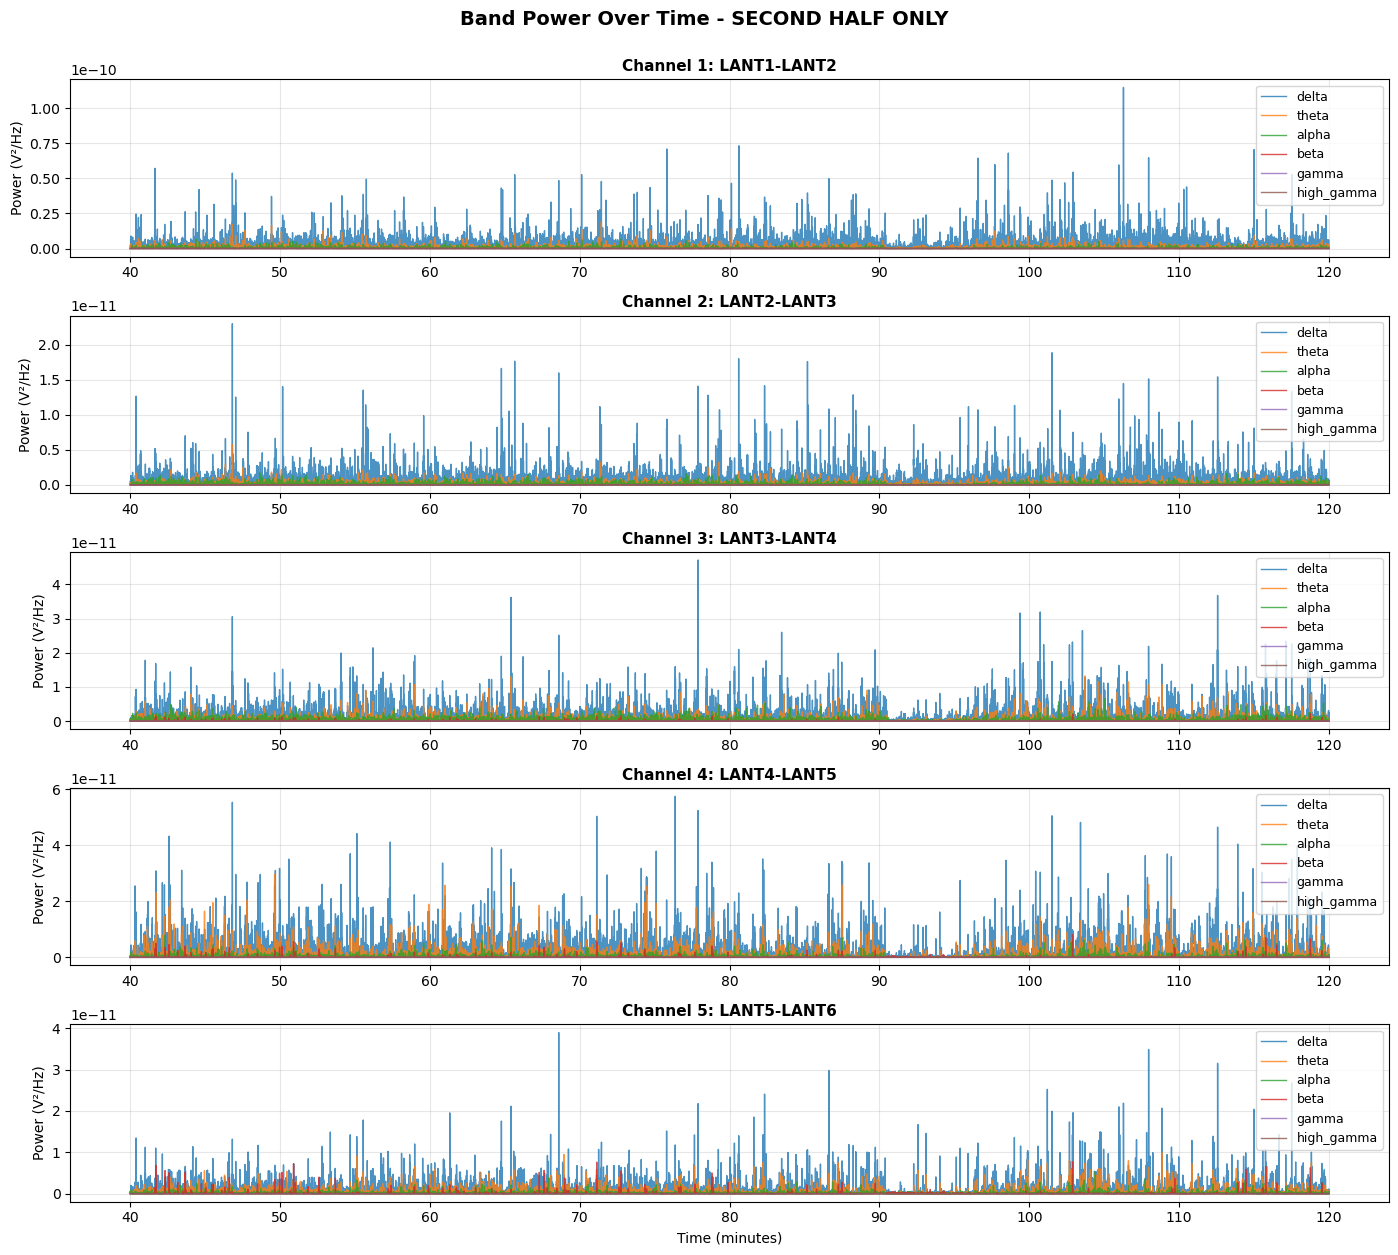


✓ VALIDATION COMPLETE - Review plots above

Analyzing SECOND HALF of recording:
- Are there visible oscillations/variations?
- Are different bands showing different power levels?
- Are there any flat lines or suspicious patterns?

If second half looks good but overall plots looked bad,
then artifacts are likely in the FIRST half of the recording.


In [32]:
# ============================================================================
# VALIDATION: Check band power data - SECOND HALF ONLY
# ============================================================================
import matplotlib.pyplot as plt

print("\n" + "=" * 70)
print("VALIDATION: Checking band power data (SECOND HALF ONLY)")
print("=" * 70)

# Basic checks
print(f"\nData shape: {band_power_time.shape}")
print(f"  (time_windows={band_power_time.shape[0]}, channels={band_power_time.shape[1]}, bands={band_power_time.shape[2]})")

# Calculate second half indices
n_windows_total = band_power_time.shape[0]
halfway_idx = n_windows_total // 3

# Extract second half only
band_power_second_half = band_power_time[halfway_idx:, :, :]
times_second_half = times[halfway_idx:]

print(f"\nFocusing on SECOND HALF:")
print(f"  Time window range: {times_second_half[0]/60:.1f} - {times_second_half[-1]/60:.1f} minutes")
print(f"  Number of windows: {len(times_second_half)}")

# Check for issues (second half only)
has_nan = np.any(np.isnan(band_power_second_half))
has_inf = np.any(np.isinf(band_power_second_half))
all_zero = np.allclose(band_power_second_half, 0)

print(f"\nData quality checks (second half):")
print(f"  Has NaN: {has_nan}")
print(f"  Has Inf: {has_inf}")
print(f"  All zeros: {all_zero}")

# Statistics per band (second half only)
print(f"\nPer-band statistics (SECOND HALF ONLY):")
for band_idx, (band_name, (fmin, fmax)) in enumerate(BANDS.items()):
    band_data = band_power_second_half[:, :, band_idx]
    print(f"  {band_name:12s} ({fmin:3.0f}-{fmax:3.0f} Hz): mean={band_data.mean():.3e}, std={band_data.std():.3e}, range=[{band_data.min():.3e}, {band_data.max():.3e}]")

# Quick visualization - plot first few channels (second half only)
print(f"\nPlotting first 5 channels - SECOND HALF only...")

n_channels_to_plot = min(5, band_power_time.shape[1])
time_plot = times_second_half / 60  # Convert to minutes

fig, axes = plt.subplots(n_channels_to_plot, 1, figsize=(14, 2.5 * n_channels_to_plot))

if n_channels_to_plot == 1:
    axes = [axes]

for ch_idx in range(n_channels_to_plot):
    ax = axes[ch_idx]
    
    # Get channel name
    pair = pairs[ch_idx]
    channel_name = pair['location']
    
    # Plot each frequency band (second half only)
    for band_idx, band_name in enumerate(BANDS.keys()):
        power_trace = band_power_second_half[:, ch_idx, band_idx]
        ax.plot(time_plot, power_trace, label=band_name, linewidth=1, alpha=0.8)
    
    ax.set_ylabel('Power (V²/Hz)', fontsize=10)
    ax.set_title(f'Channel {ch_idx+1}: {channel_name}', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Only show x-label on bottom plot
    if ch_idx == n_channels_to_plot - 1:
        ax.set_xlabel('Time (minutes)', fontsize=10)

plt.suptitle('Band Power Over Time - SECOND HALF ONLY', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✓ VALIDATION COMPLETE - Review plots above")
print("=" * 70)
print("\nAnalyzing SECOND HALF of recording:")
print("- Are there visible oscillations/variations?")
print("- Are different bands showing different power levels?")
print("- Are there any flat lines or suspicious patterns?")
print("\nIf second half looks good but overall plots looked bad,")
print("then artifacts are likely in the FIRST half of the recording.")

In [33]:
step_start = time.time()

print("\n" + "=" * 70)
print(f"STEP 4: Creating enhanced electrode table")
print("=" * 70)

bipolar_elec_df = create_bipolar_electrode_table(elec_df, pairs)

print(f"✓ Electrode table: {len(bipolar_elec_df)} rows × {len(bipolar_elec_df.columns)} columns")
print(f"  Time: {time.time() - step_start:.2f}s")
print(f"  Total elapsed: {time.time() - start_time:.1f}s")

# Show sample
print("\nSample electrode table columns:")
print(f"  Coordinate columns: {[c for c in bipolar_elec_df.columns if 'coord' in c][:6]}")
print(f"  Anode columns: {[c for c in bipolar_elec_df.columns if '_anode' in c][:3]}")
print(f"  Cathode columns: {[c for c in bipolar_elec_df.columns if '_cathode' in c][:3]}")


STEP 4: Creating enhanced electrode table
✓ Electrode table: 214 rows × 67 columns
  Time: 0.04s
  Total elapsed: 1770052550.3s

Sample electrode table columns:
  Coordinate columns: ['MNI_coord_1', 'MNI_coord_2', 'MNI_coord_3', 'LEPTO_coord_1', 'LEPTO_coord_2', 'LEPTO_coord_3']
  Anode columns: ['chan_num_anode', 'FS_label_anode', 'FS_vol_anode']
  Cathode columns: ['chan_num_cathode', 'FS_label_cathode', 'FS_vol_cathode']


In [34]:
step_start = time.time()

print("\n" + "=" * 70)
print(f"STEP 5: Building NWB structure")
print("=" * 70)

# Create new subject object (don't reuse from input)
if nwb_in.subject is not None:
    subject_out = pynwb.file.Subject(
        subject_id=nwb_in.subject.subject_id,
        age=nwb_in.subject.age if hasattr(nwb_in.subject, 'age') else None,
        sex=nwb_in.subject.sex if hasattr(nwb_in.subject, 'sex') else None,
        species=nwb_in.subject.species if hasattr(nwb_in.subject, 'species') else None,
        description=nwb_in.subject.description if hasattr(nwb_in.subject, 'description') else None
    )
else:
    subject_out = None

# Create output NWB
nwb_out = NWBFile(
    session_description=nwb_in.session_description + " - bipolar referenced, band power computed",
    identifier=nwb_in.identifier + "_bipolar_psd",
    session_start_time=nwb_in.session_start_time,
    timestamps_reference_time=nwb_in.timestamps_reference_time,
    file_create_date=datetime.now().astimezone(),
    experimenter=nwb_in.experimenter,
    lab=nwb_in.lab,
    institution=nwb_in.institution,
    subject=subject_out  # Use new subject object
)

# Create device
device = nwb_out.create_device(
    name='NihonKohden',
    description='Nihon Kohden EEG-1200A'
)

# Create electrode group
elec_group = nwb_out.create_electrode_group(
    name='sEEG_bipolar',
    description='Bipolar referenced sEEG electrodes (anode-cathode pairs)',
    location='multiple',
    device=device
)

print("✓ Basic NWB structure created")
print(f"  Time: {time.time() - step_start:.2f}s")


STEP 5: Building NWB structure
✓ Basic NWB structure created
  Time: 0.00s


In [35]:
step_start = time.time()

print("\n" + "=" * 70)
print(f"STEP 6: Adding custom electrode columns")
print("=" * 70)

# Get all custom columns (exclude 'location', 'group', 'group_name')
standard_columns = ['location', 'group', 'group_name']
custom_columns = [col for col in bipolar_elec_df.columns if col not in standard_columns]

print(f"Adding {len(custom_columns)} custom columns...")

# Add each custom column with its actual data
for col in custom_columns:
    # Get the column data as a list
    col_data = bipolar_elec_df[col].tolist()
    
    # Add column with description
    nwb_out.add_electrode_column(
        name=col,
        description=f'Custom column: {col}'
    )
    
    if (custom_columns.index(col) + 1) % 10 == 0:
        print(f"  Progress: {custom_columns.index(col) + 1}/{len(custom_columns)}", end='\r')

print()
print(f"✓ Custom columns added")
print(f"  Time: {time.time() - step_start:.2f}s")


STEP 6: Adding custom electrode columns
Adding 64 custom columns...
  Progress: 60/64
✓ Custom columns added
  Time: 0.02s


In [36]:
step_start = time.time()

print("\n" + "=" * 70)
print(f"STEP 7: Adding electrode rows")
print("=" * 70)

# Add electrode rows
for idx, row in bipolar_elec_df.iterrows():
    electrode_kwargs = {'group': elec_group}
    
    for col in bipolar_elec_df.columns:
        if col not in ['group', 'group_name']:
            electrode_kwargs[col] = row[col]
    
    nwb_out.add_electrode(**electrode_kwargs)
    
    if (idx + 1) % 20 == 0 or idx == len(bipolar_elec_df) - 1:
        print(f"  Progress: {idx + 1}/{len(bipolar_elec_df)} electrodes", end='\r')

print()
print(f"✓ Electrodes added")
print(f"  Time: {time.time() - step_start:.2f}s")


STEP 7: Adding electrode rows
  Progress: 214/214 electrodes
✓ Electrodes added
  Time: 0.35s


In [37]:
step_start = time.time()

print("\n" + "=" * 70)
print(f"STEP 8: Adding band power decomposition")
print("=" * 70)

# Create electrode table region
electrode_region = nwb_out.create_electrode_table_region(
    region=list(range(len(pairs))),
    description='bipolar electrode pairs with averaged coordinates'
)

# Create processing module
ecephys_module = nwb_out.create_processing_module(
    name='ecephys',
    description='Processed electrophysiology data including bipolar referencing and band power'
)

# Add DecompositionSeries
sampling_rate = 1.0 / (times[1] - times[0])

decomp_series = DecompositionSeries(
    name='band_power',
    description=f'Time-varying power in frequency bands (window=1.0s, overlap=0.5s). '
                f'Source data was bipolar referenced (adjacent electrode pairs: anode-cathode).',
    data=band_power_time,
    metric='power',
    unit='V^2/Hz',
    rate=sampling_rate,
    source_channels=electrode_region
)

# Add bands
for band_name, band_limits in BANDS.items():
    decomp_series.add_band(band_name=band_name, band_limits=band_limits)

ecephys_module.add(decomp_series)

print(f"✓ Band power data added")
print(f"  Sampling rate: {sampling_rate:.2f} Hz")
print(f"  Time: {time.time() - step_start:.2f}s")


STEP 8: Adding band power decomposition
✓ Band power data added
  Sampling rate: 4.00 Hz
  Time: 0.00s


In [38]:
step_start = time.time()

print("\n" + "=" * 70)
print(f"STEP 9: Writing to disk")
print("=" * 70)

# Create output directory if it doesn't exist
output_dir = os.path.dirname(OUTPUT_PATH)
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)
    print(f"✓ Created output directory: {output_dir}")

print(f"Output: {OUTPUT_PATH}")
print(f"Started at: {time.strftime('%H:%M:%S')}")

with pynwb.NWBHDF5IO(OUTPUT_PATH, 'w') as io_out:
    io_out.write(nwb_out)

io_in.close()

write_time = time.time() - step_start
file_size_mb = os.path.getsize(OUTPUT_PATH) / (1024**2)

total_time = time.time() - start_time

print(f"✓ Written in {write_time:.1f}s")
print(f"  File size: {file_size_mb:.1f} MB")

print("\n" + "=" * 70)
print("✓ COMPLETED SUCCESSFULLY")
print(f"  Total time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print("=" * 70)


STEP 9: Writing to disk
Output: /mnt/NAS/iEEG_EHR_converted/fft/sub-259/ses-01/ieeg/sub-259_ses-01_run-IA6194BZ_bipolar_psd.nwb
Started at: 09:17:54
✓ Written in 1.3s
  File size: 282.7 MB

✓ COMPLETED SUCCESSFULLY
  Total time: 1770052565.9s (29500876.1 minutes)
